In [80]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace

import pySPEC as ps
from pySPEC.time_marching import SWHD_1D, Adjoint_SWHD_1D

param_path = '/home/lpancotto/code/tesis/adjoint/pySPEC/examples/adjoint_lbfgs2'
# param_path = '/home/lpancotto/code/tesis/adjoint/pySPEC/examples/adjoint_sgd_SimpleGauss'

# Parse JSON into an object with attributes corresponding to dict keys.
fpm = json.load(open(f'{param_path}/params.json', 'r'), object_hook=lambda d: SimpleNamespace(**d))
fpm.Lx = 2*np.pi*fpm.Lx
fpm.out_path = fpm.forward_out_path
fpm.ostep = fpm.forward_ostep
# Parse JSON into an object with attributes corresponding to dict keys.
bpm = json.load(open(f'{param_path}/params.json', 'r'), object_hook=lambda d: SimpleNamespace(**d))
bpm.Lx = 2*np.pi*bpm.Lx
bpm.out_path = bpm.backward_out_path
bpm.ostep = bpm.backward_ostep
grid   = ps.Grid1D(fpm)


In [81]:
Nt = round(fpm.T/fpm.dt)
h_uxs =   np.load(f'{bpm.out_path}/h_ux_memmap.npy', mmap_mode='r') # all uu fields in time
hx_uus =  np.load(f'{bpm.out_path}/hx_uu_memmap.npy', mmap_mode='r')  # all t hx_uu

uus =  np.load(f'{fpm.out_path}/uu_memmap.npy', mmap_mode='r')  # all t hx_uu


In [82]:
hx_uus

memmap([[-8.94297796e-09, -8.82698874e-09, -8.69224799e-09, ...,
         -9.15038021e-09, -9.10775281e-09, -9.03754419e-09],
        [-1.78834914e-08, -1.76505286e-08, -1.73802323e-08, ...,
         -1.83024483e-08, -1.82155898e-08, -1.80737955e-08],
        [-2.68214852e-08, -2.64705729e-08, -2.60639136e-08, ...,
         -2.74561189e-08, -2.73234368e-08, -2.71086897e-08],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [16]:
def get_dg_stats(h_uxs):
    # h_ux mean and max
    mh_uxs = [h_ux.mean() for h_ux in h_uxs]
    Mh_uxs = [h_ux.max() for h_ux in h_uxs]
    # argmaxh_ux =  np.argmax(np.array(mh_uxs))
    # maxh_ux =  np.array(mh_uxs).max()
    # integrate h_ux in time
    Th_uxs = np.trapz(np.array(h_uxs), dx = -1e-4, axis = 0) # -dt because integration is from T to t=0
    print('check shape of integral h_ux :  ' , Th_uxs.shape)
    # integrate h_ux in time and space
    XTh_uxs = np.trapz(Th_uxs ,  dx = 2*np.pi/len(Th_uxs))
    print('integral in space-time h_ux = ', XTh_uxs)
    return mh_uxs, Mh_uxs, Th_uxs, XTh_uxs

In [17]:
mh_uxs, Mh_uxs, Th_uxs, XTh_uxs = get_dg_stats(h_uxs)
mhx_uus,  Mhx_uus , Thx_uus, XThx_uus = get_dg_stats(hx_uus)

tts = [tt for tt in range(len(h_uxs))]

# get uu for argmaxh_ux
argmaxh_ux =  np.argmax(np.array(mh_uxs))
maxh_ux =  np.array(mh_uxs).max()
# load
hh_max = np.load(f'{fpm.data_path}/hh_{argmaxh_ux:04}.npy')
hb = np.load(f'{fpm.data_path}/hb.npy')


check shape of integral h_ux :   (1024,)
integral in space-time h_ux =  -0.0018296287991606884
check shape of integral h_ux :   (1024,)
integral in space-time h_ux =  0.001829610309384222


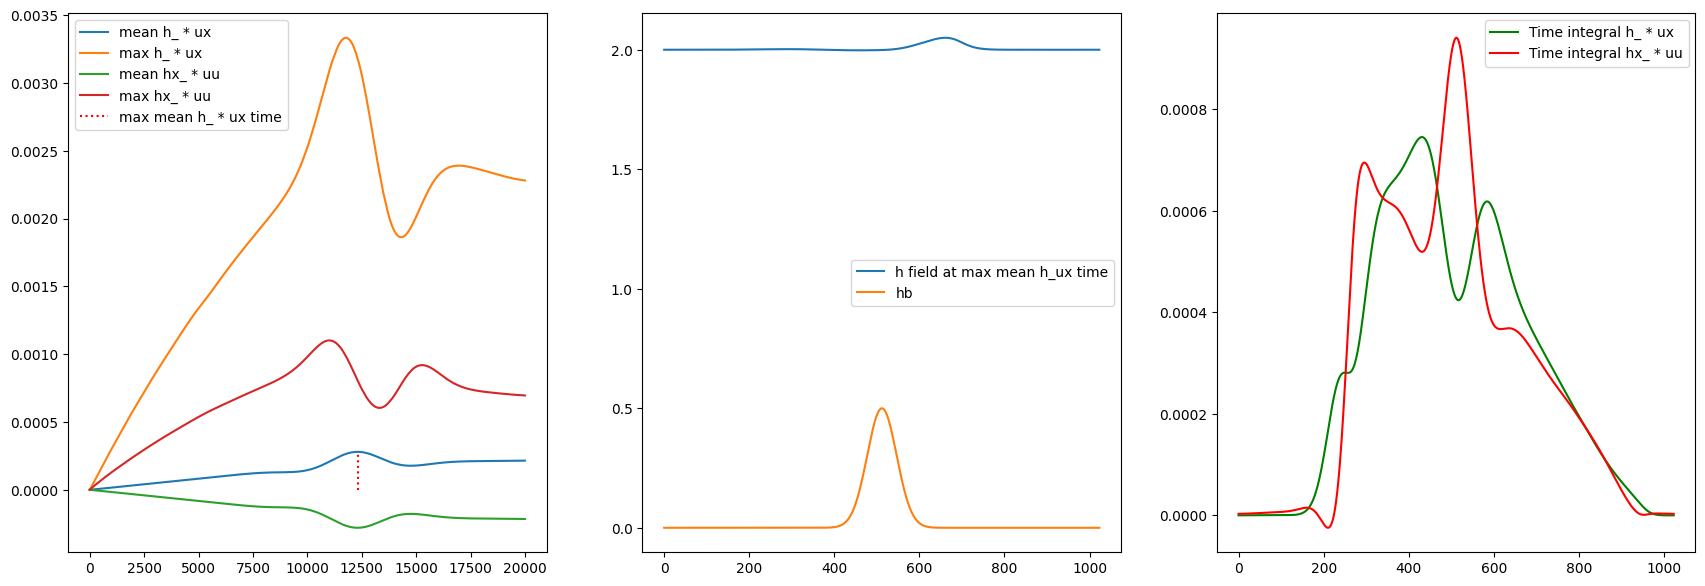

In [22]:
f,axs = plt.subplots(ncols=3 , figsize = (21,7))

axs[0].plot(tts , mh_uxs , label = 'mean h_ * ux' )
axs[0].plot(tts , Mh_uxs , label = 'max h_ * ux' )
axs[0].plot(tts , mhx_uus , label = 'mean hx_ * uu' )
axs[0].plot(tts , Mhx_uus , label = 'max hx_ * uu' )
axs[0].vlines(argmaxh_ux , 0 , maxh_ux, linestyles='dotted', color = 'red', label = 'max mean h_ * ux time')
axs[0].legend()

axs[1].plot(hh_max, label = 'h field at max mean h_ux time')
axs[1].plot(hb, label = 'hb')
axs[1].legend()

axs[2].plot(- Th_uxs , alpha = 1, color = 'green' , label = 'Time integral h_ * ux')
axs[2].plot(Thx_uus , alpha = 1, color = 'red' , label = 'Time integral hx_ * uu')
# axs[2].plot(hh_max, label = 'h field at max mean h_ux time' , alpha = 0.4 , color = 'green')
# axs[2].plot(hb*1e-4, label = 'hb' , alpha = 0.4 , color = 'brown')
axs[2].legend()


zero modes for adjoint states

In [19]:
adjoint_zero_modes = [np.load(f'{bpm.out_path}/adjoint_zero_modes_{step:04}.npy') for step in range(Nt)] # zero modes for adjoint states

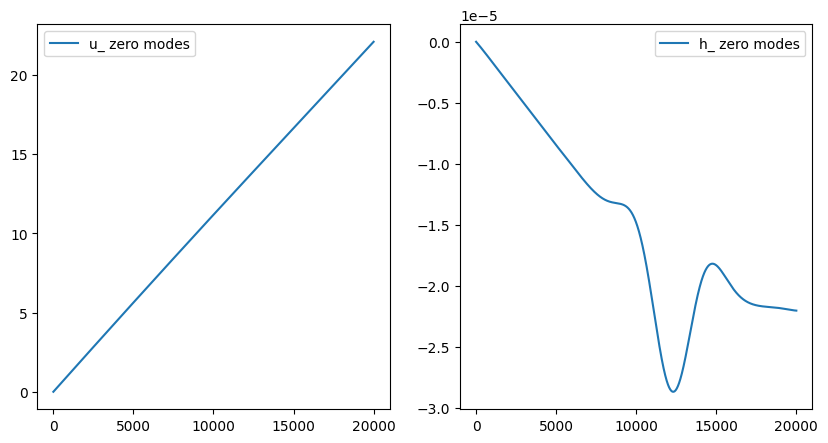

In [20]:
adjoint_zero_modes = np.array(adjoint_zero_modes )
adjoint_zero_modes.shape

f,axs = plt.subplots(ncols=2, figsize  = (10,5))
axs[0].plot(adjoint_zero_modes[:,0] , label = 'u_ zero modes')
axs[1].plot(adjoint_zero_modes[:,1] , label = 'h_ zero modes')
axs[0].legend()
axs[1].legend()